In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbimporter
import mainstream_tests
# from matplotlib import rc
# rc('text', usetex=True)

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("ticks")

Importing Jupyter notebook from mainstream_tests.ipynb


In [2]:
def get_songs_data(cleaned_data, recommended=True, obs_threshold=7, separate_rec=True):
    """
    Gets the number of songs and plays for each user (calculates S/P diversity index)
    :param obs_threshold: user must have this number of observations of more to be kept in the dataset
    :param cleaned_data: data after removing outliers
    :param recommended: gets the recommended part of the dataset if True, the organic part otherwise
    :return: a pandas Series with [user_id, S/P] as its rows
    """
    if separate_rec:
        # Separating based on entry's origin -- should use map function if refactoring ever occurs
        if recommended:
            songs_data = cleaned_data[cleaned_data["origin"].str.contains("flow|reco")]
        else:
            songs_data = cleaned_data[~cleaned_data["origin"].str.contains("flow|reco")]
    else:
        songs_data = cleaned_data
    
    # Computing for each user every S and their respective P
    songs_data = songs_data.groupby(["user_id", "sng_id"]).size()

    # Determine and drop cases with too few observations (see obs_threshold)
    thresh_tester = songs_data.sum(level="user_id")
    thresh_tester = thresh_tester[thresh_tester < obs_threshold]
    songs_data.drop(thresh_tester.index.values, inplace=True)

    # No exception will be raised even on empty series (in case no value is above obs-threshold)
    songs_data = songs_data.groupby(["user_id"]).size().divide(songs_data.sum(level="user_id"))
    return songs_data

In [86]:
FILE_NAME = "../../data/data_binned_clean.csv"

MIN_REC = 17
MIN_ORG = 83

MU_BINS = np.arange(1, 5, 1)

print("Reading data...")
data = pd.read_csv(FILE_NAME)
data

Reading data...


,user_id,ts,sng_id,album_id,listening_time,listen_type,origin,art_id,bin_mn,recommended,bin_u
0,53a2a460127df49eef5976193c14728c695c3463,1471344689,121710324,12721422,203,MOD,page_playlist,249599,2,False,2
1,53a2a460127df49eef5976193c14728c695c3463,1473857854,121710324,12721422,203,MOD,page_playlist,249599,2,False,2
2,53a2a460127df49eef5976193c14728c695c3463,1474463898,121710324,12721422,202,MOD,user_library,249599,2,False,2
3,53a2a460127df49eef5976193c14728c695c3463,1474709567,121710324,12721422,203,MOD,page_playlist,249599,2,False,2
4,53a2a460127df49eef5976193c14728c695c3463,1474809916,121710324,12721422,196,MOD,page_playlist,249599,2,False,2
...,...,...,...,...,...,...,...,...,...,...,...
1367830,868eb4e1ad62fc0f6c68e27c5bc0cc533bc07f54,1478883737,3039816,294809,229,MOD,page_playlist,961,4,False,1
1367831,868eb4e1ad62fc0f6c68e27c5bc0cc533bc07f54,1479197769,3039816,294809,230,MOD,page_playlist,961,4,False,1
1367832,868eb4e1ad62fc0f6c68e27c5bc0cc533bc07f54,1479404701,3039816,294809,229,MOD,page_playlist,961,4,False,1
1367833,868eb4e1ad62fc0f6c68e27c5bc0cc533bc07f54,1479715420,3039816,294809,230,MOD,page_playlist,961,4,False,1


In [4]:
# Isolating user bin data
user_bin_data = data.drop_duplicates("user_id").reset_index().drop("index", axis=1)[["user_id", "bin_u"]]
user_bin_data

,user_id,bin_u
0,53a2a460127df49eef5976193c14728c695c3463,2
1,b26ce863e9161cc7e36cdf254927457cc5ceb55b,2
2,206929899c1bfc3c49174d20824ab1dc77758567,3
3,111f74340b5ef733f7dc99dc5494de3da4dbeea7,4
4,5f935bea161673f83b0645325bc3da5d113b7f91,3
...,...,...
1008,ec55f3d9afa8e417326f1eef0d1c9b07472b9061,1
1009,489493cedeed5d97c1d40949c4b27a86ec396a74,2
1010,95030e4862b62888702f1c18910889b9a5de05e1,1
1011,5dcdf656151725db91012936a3995166d202dc15,3


## Po/Pr

In [5]:
data["reco"] = data["origin"].map(mainstream_tests.is_reco)
rec_org_plays = data.groupby(["user_id", "reco"]).size().to_frame().reset_index()
rec_org_plays = rec_org_plays[rec_org_plays["reco"] == False].merge(rec_org_plays[rec_org_plays["reco"] == True], on="user_id").drop(["reco_x", "reco_y"], axis=1)
rec_org_plays.columns = ["user_id", "Po", "Pr"]
rec_org_plays

,user_id,Po,Pr
0,00877d231a1d10859eefd4288ecc493fd1ea3589,2263,1901
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,2063,451
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,1290,5
3,0282983996af7f6b2a27cfff67fc8982619561d6,1498,314
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,1017,136
...,...,...,...
933,fe016f7c946213bd53ca9b683b7314d24d2dbba9,622,36
934,fe22a3978a595c3a63cb40558db7804956f8e1d7,440,8
935,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,738,5
936,fea927761d221701b2bf1b6acc2de6d91d060071,2808,12


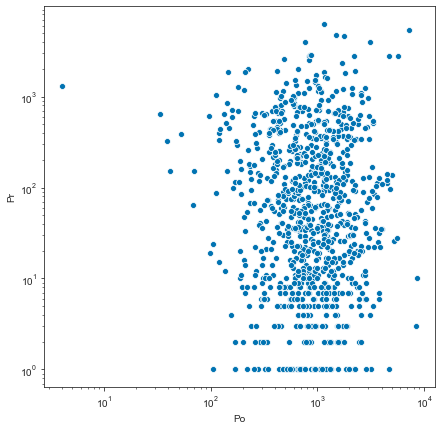

In [6]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x="Po", y="Pr", data=rec_org_plays)
plt.savefig("../../results/plays_rec_org_loglog.pdf")

## So/Po vs Sr/Pr

In [7]:
print("Computing diversity ratio...")
rec_data = get_songs_data(data, recommended=True, obs_threshold=0)
org_data = get_songs_data(data, recommended=False, obs_threshold=0)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
org_data = org_data.to_frame()
rec_data = rec_data.to_frame()
org_data.index.names = ["user"]
rec_data.index.names = ["user"]
org_data.columns = ["ratio"]
rec_data.columns = ["ratio"]
org_data["recommended"] = 0
rec_data["recommended"] = 1
org_data = pd.concat([org_data, rec_data])
org_data = org_data.reset_index()

org_data

Computing diversity ratio...
Organizing data...


,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259832,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.278720,0
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272093,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.384513,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512291,0
...,...,...,...
1946,fe016f7c946213bd53ca9b683b7314d24d2dbba9,1.000000,1
1947,fe22a3978a595c3a63cb40558db7804956f8e1d7,1.000000,1
1948,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1
1949,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1


In [8]:
# Remove singletons
org_data = org_data[org_data.groupby("user").user.transform(len) > 1]
org_data

,user,ratio,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259832,0
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.278720,0
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272093,0
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.384513,0
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512291,0
...,...,...,...
1946,fe016f7c946213bd53ca9b683b7314d24d2dbba9,1.000000,1
1947,fe22a3978a595c3a63cb40558db7804956f8e1d7,1.000000,1
1948,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1
1949,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1


In [9]:
# Adding user bins
u_bins = pd.read_csv("../../data/user_bins.csv")
u_bins.columns = ["user", "rate", "plays", "u_bin_nb"]
org_data = org_data.merge(u_bins, on="user")
org_data

,user,ratio,recommended,rate,plays,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259832,0,0.456532,4164,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,0.375592,1,0.456532,4164,4
2,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.278720,0,0.179395,2514,3
3,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.532151,1,0.179395,2514,3
4,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272093,0,0.003861,1295,1
...,...,...,...,...,...,...
1871,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,1.000000,1,0.006729,743,1
1872,fea927761d221701b2bf1b6acc2de6d91d060071,0.078348,0,0.004255,2820,1
1873,fea927761d221701b2bf1b6acc2de6d91d060071,1.000000,1,0.004255,2820,1
1874,ff7672529f1387bf35e1296f79009275287980a8,0.184661,0,0.004113,1702,1


In [10]:
# Grouping data into one df
ratio_data = org_data[org_data["recommended"] == 0].merge(org_data[org_data["recommended"] == 1][["user", "ratio"]], on="user").drop("recommended", axis=1)
ratio_data.columns = ["user", "ratio_org", "rate", "plays", "bin_u", "ratio_rec"]
ratio_data

,user,ratio_org,rate,plays,bin_u,ratio_rec
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259832,0.456532,4164,4,0.375592
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.278720,0.179395,2514,3,0.532151
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272093,0.003861,1295,1,0.400000
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.384513,0.173289,1812,3,0.904459
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512291,0.117953,1153,3,0.772059
...,...,...,...,...,...,...
933,fe016f7c946213bd53ca9b683b7314d24d2dbba9,0.350482,0.054711,658,3,1.000000
934,fe22a3978a595c3a63cb40558db7804956f8e1d7,0.413636,0.017857,448,2,1.000000
935,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,0.398374,0.006729,743,1,1.000000
936,fea927761d221701b2bf1b6acc2de6d91d060071,0.078348,0.004255,2820,1,1.000000


In [11]:
x = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["ratio"]
y = org_data[org_data["recommended"] == 1].reset_index().drop("index", axis=1)["ratio"]
classes = org_data[org_data["recommended"] == 0].reset_index().drop("index", axis=1)["u_bin_nb"].rename(r"bin\_u")

classes.groupby(classes).size()

bin\_u
1    176
2    264
3    286
4    212
Name: bin\_u, dtype: int64

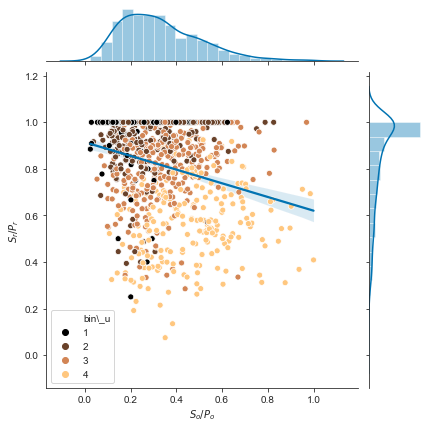

In [12]:
sns.jointplot(x, y, kind='reg', scatter=False)
ax = sns.scatterplot(x, y, hue=classes, palette="copper")
ax.set(xlabel=r"$S_o/P_o$", ylabel=r"$S_r/P_r$")
plt.savefig("../../results/sp_ratio_ratio_ubins_17rec_83org.pdf")

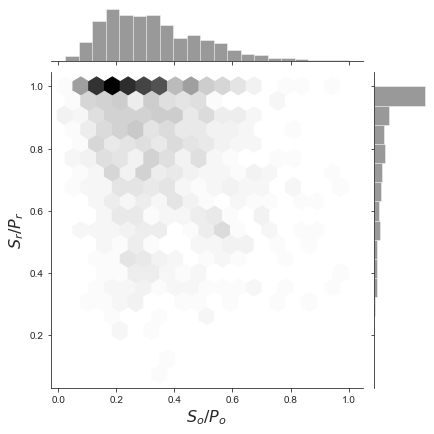

In [13]:
h = sns.jointplot(x, y, kind='hex', color="k")
h.set_axis_labels(r"$S_o/P_o$", r"$S_r/P_r$", fontsize=16)
plt.savefig("../../results/sp_ratio_ratio_hex.pdf")

In [14]:
ratio_data["quantile_org"] = pd.cut(ratio_data["ratio_org"], 5)
ratio_data["quantile_rec"] = pd.cut(ratio_data["ratio_rec"], 5)
ratio_means = ratio_data.groupby(["quantile_org", "bin_u"]).mean()["ratio_rec"].to_frame().reset_index().drop("quantile_org", axis=1)
ratio_means["ratio_org"] = np.repeat(np.arange(0.1, 1.0, 0.2), 4)

ratio_means_vert = ratio_data.groupby(["quantile_rec", "bin_u"]).mean()["ratio_org"].to_frame().reset_index().drop("quantile_rec", axis=1)
ratio_means_vert["ratio_rec"] = np.repeat(np.arange(0.1, 1.0, 0.2), 4)

ratio_means.columns = ["bin_u", "ratiorectot", "ratioorgtot"]
ratio_means_vert.columns = ["bin_u", "ratioorgvert", "ratiorecvert"]

ratio_data = ratio_data.append(ratio_means, ignore_index=True)
ratio_data = ratio_data.append(ratio_means_vert, ignore_index=True)
ratio_data

,user,ratio_org,rate,plays,bin_u,ratio_rec,quantile_org,quantile_rec,ratiorectot,ratioorgtot,ratioorgvert,ratiorecvert
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259832,0.456532,4164.0,4,0.375592,"(0.219, 0.414]","(0.26, 0.445]",NaN,NaN,NaN,NaN
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.278720,0.179395,2514.0,3,0.532151,"(0.219, 0.414]","(0.445, 0.63]",NaN,NaN,NaN,NaN
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272093,0.003861,1295.0,1,0.400000,"(0.219, 0.414]","(0.26, 0.445]",NaN,NaN,NaN,NaN
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.384513,0.173289,1812.0,3,0.904459,"(0.219, 0.414]","(0.815, 1.0]",NaN,NaN,NaN,NaN
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.512291,0.117953,1153.0,3,0.772059,"(0.414, 0.61]","(0.63, 0.815]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
973,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,0.491316,0.7
974,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0.225638,0.9
975,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0.286218,0.9
976,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,0.385537,0.9


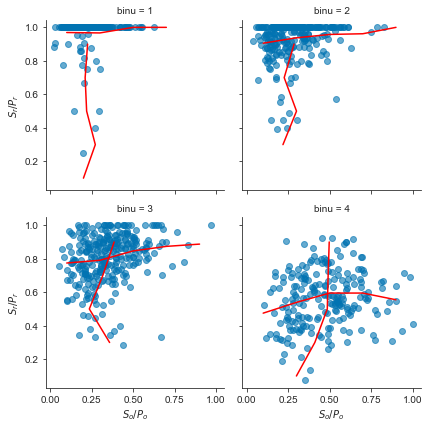

In [15]:
# Workaround to avoid LaTeX explosion
ratio_data.columns = ["user", "ratioorg", "rate", "plays", "binu", "ratiorec", "quantileorg", "quantilerec", "ratiorectot", "ratioorgtot", "ratioorgvert", "ratiorecvert"]

g = sns.FacetGrid(ratio_data, col="binu", col_wrap=2)
g.map(plt.scatter, "ratioorg", "ratiorec", alpha=0.6)
g.map(sns.lineplot, "ratioorgtot", "ratiorectot", color="r")
g.map(sns.lineplot, "ratioorgvert", "ratiorecvert", color="r", sort=False)
g.axes[2].set_xlabel("$S_o/P_o$")
g.axes[3].set_xlabel("$S_o/P_o$")
g.axes[2].set_ylabel("$S_r/P_r$")
g.axes[0].set_ylabel("$S_r/P_r$")
plt.savefig("../../results/sp_ratio_ratio_ubins_distinct.pdf")

# sns.lineplot(x="rate", y="ratio", data=sp_means, ax=h.ax_joint, color="r", markers=True)

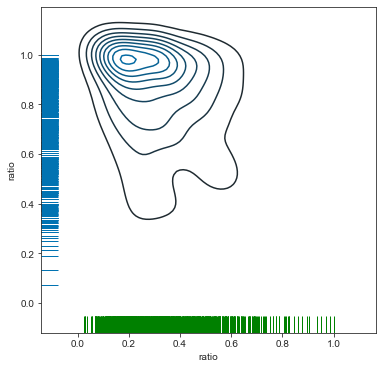

In [16]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x, y, ax=ax)
sns.rugplot(x, color="g", ax=ax)
sns.rugplot(y, vertical=True, ax=ax);

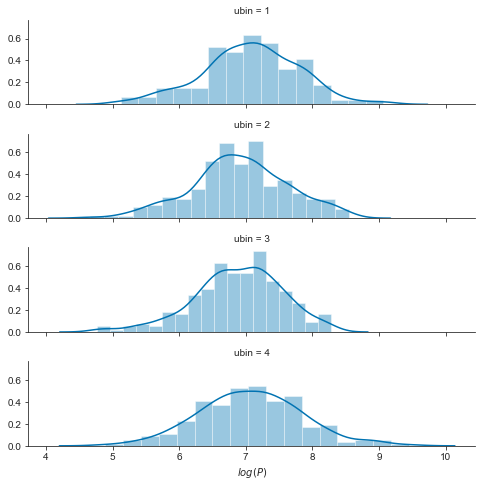

In [17]:
org_data["logplays"] = org_data["plays"].map(np.log)
g = sns.FacetGrid(org_data.rename(columns={"u_bin_nb": "ubin"}), row="ubin", height=1.7, aspect=4)
g.map(sns.distplot, "logplays")
g.axes[3, 0].set_xlabel("$log(P)$")
plt.savefig("../../results/pdist_ubins.png")

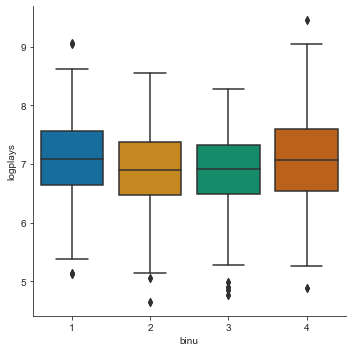

In [18]:
sns.catplot(x="binu", y="logplays", data=org_data.rename(columns={"u_bin_nb": "binu"}), kind="box")

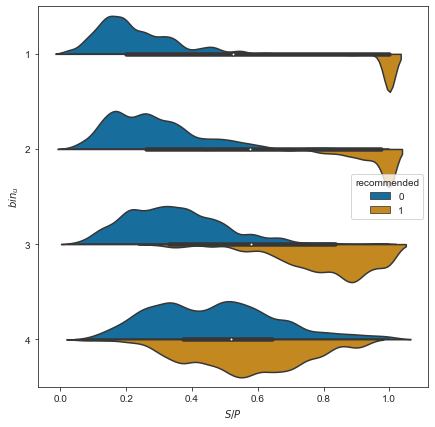

In [19]:
org_data["u_bin_nb"] = org_data["u_bin_nb"].astype('category')
f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(x="ratio", y="ubin", hue="recommended",  scale="count", scale_hue=True, data=org_data.rename(columns={"u_bin_nb": "ubin"}), split=True, bw=0.17, inner="box")
ax.set(ylabel="$bin_u$", xlabel="$S/P$")
plt.savefig("../../results/sp_ratio_violin_bin_u_pdist.png")

In [20]:
org_data["logplays"] = org_data["plays"].map(np.log)
org_data["quantile"] = pd.cut(org_data["ratio"], np.arange(0, 1.05, 0.05))
sp_list = org_data.groupby(["u_bin_nb", "recommended", "quantile"]).size().to_frame().reset_index()
sp_list["logplays"] = org_data.groupby(["u_bin_nb", "recommended", "quantile"])["logplays"].mean().to_frame().reset_index()["logplays"]
sp_list.to_csv("../../data/sp_data.csv", index=False)

In [21]:
# Getting total S/P ratio for each user
print("Computing diversity ratio...")
sp_data = get_songs_data(data, obs_threshold=0, separate_rec=False)

print("Organizing data...")
# get_songs_data produces a pd.Series, which we turn into a DataFrame before adjusting some column names
sp_data = sp_data.to_frame()
sp_data.index.names = ["user"]
sp_data.columns = ["ratio"]

sp_data = sp_data.merge(u_bins, on="user")
sp_data

Computing diversity ratio...
Organizing data...


,user,ratio,rate,plays,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.259606,0.456532,4164,4
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,0.273667,0.179395,2514,3
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,0.272587,0.003861,1295,1
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.451987,0.173289,1812,3
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.510841,0.117953,1153,3
...,...,...,...,...,...
1008,fe22a3978a595c3a63cb40558db7804956f8e1d7,0.415179,0.017857,448,2
1009,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,0.399731,0.006729,743,1
1010,fea927761d221701b2bf1b6acc2de6d91d060071,0.080496,0.004255,2820,1
1011,ff7672529f1387bf35e1296f79009275287980a8,0.184489,0.004113,1702,1


In [22]:
# f, ax = plt.subplots(figsize=(7, 7))
# h = sns.jointplot(x="rate", y="ratio", data=sp_data, alpha=0.6)
# sns.lineplot(x="rate", y="ratio", data=sp_means, ax=h.ax_joint, color="r", markers=True)
# h.set_axis_labels(r'$\rho$', r'$S/P$', fontsize=16)
# plt.savefig("../../results/sp_rho_scatter_meanbins.pdf")

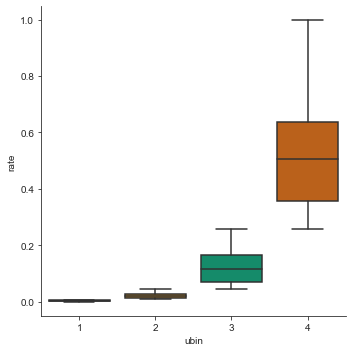

In [28]:
sns.catplot(x="ubin", y="ratio", data=sp_data.rename(columns={"u_bin_nb": "ubin"}), kind="box")
plt.savefig("../../results/sp_ubins.pdf")

In [24]:
sp_data["logplays"] = sp_data["plays"].map(np.log)
sp_data["quantile"] = pd.cut(sp_data["logplays"], np.arange(4.5, 10.5, 1))

plays_means = sp_data.groupby(["quantile"]).mean()["ratio"].to_frame().reset_index().drop("quantile", axis=1)
plays_means["logplays"] = np.arange(5, 10, 1)
plays_means

,ratio,logplays
0,0.514615,5
1,0.408043,6
2,0.318431,7
3,0.234139,8
4,0.150376,9


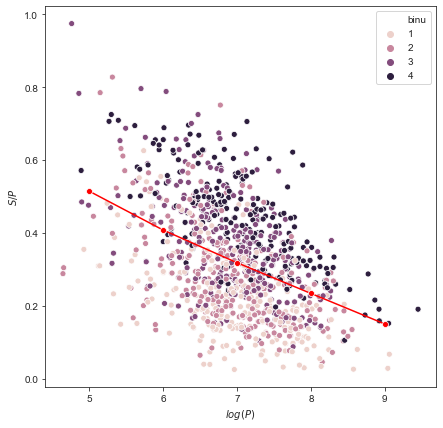

In [77]:
f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x="logplays", y="ratio", hue="binu", data=sp_data.rename(columns={"u_bin_nb": "binu"}))
sns.lineplot(x="logplays", y="ratio", data=plays_means, color="r", marker= "o")
ax.set(ylabel="$S/P$", xlabel="$log(P)$")
plt.savefig("../../results/sp_logp_bins.pdf")

## S/P and mainstream?

In [87]:
bin_mu_delta = data.groupby("user_id").mean()["bin_mn"] - MU_BINS.mean()
bin_mu_delta = bin_mu_delta.to_frame().reset_index()
bin_mu_delta = bin_mu_delta.merge(sp_data[["user", "ratio", "plays"]], left_on="user_id", right_on="user").drop("user", axis=1)
bin_mu_delta

,user_id,bin_mn,ratio,plays
0,00877d231a1d10859eefd4288ecc493fd1ea3589,0.200528,0.259606,4164
1,018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e,-0.058075,0.273667,2514
2,01d78f7619786f5f06843b5f1cb7d7b15a934731,-0.365637,0.272587,1295
3,0282983996af7f6b2a27cfff67fc8982619561d6,0.913907,0.451987,1812
4,02eae2623eaf23461bbadd9c4f3ae1f659a90809,0.167823,0.510841,1153
...,...,...,...,...
1008,fe22a3978a595c3a63cb40558db7804956f8e1d7,-0.236607,0.415179,448
1009,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,-0.296770,0.399731,743
1010,fea927761d221701b2bf1b6acc2de6d91d060071,-0.892553,0.080496,2820
1011,ff7672529f1387bf35e1296f79009275287980a8,0.058167,0.184489,1702


In [88]:
sp_mu_bins = np.arange(bin_mu_delta["bin_mn"].min(), bin_mu_delta["bin_mn"].max()+0.1, (bin_mu_delta["bin_mn"].max()-bin_mu_delta["bin_mn"].min()) / 4)
sp_mu_bins
bin_mu_delta["quantile"] = pd.cut(bin_mu_delta["bin_mn"], sp_mu_bins)

sp_mu_means = bin_mu_delta.groupby(["quantile"]).mean()["ratio"].to_frame().reset_index().drop("quantile", axis=1)

sp_mu_bins_points = []
for i in range(sp_mu_bins.size - 1):
    sp_mu_bins_points.append((sp_mu_bins[i] + sp_mu_bins[i+1]) / 2)

sp_mu_means["bin_mn"] = sp_mu_bins_points
sp_mu_means

,ratio,bin_mn
0,0.213787,-1.005762
1,0.269024,-0.337186
2,0.365442,0.331390
3,0.443021,0.999966


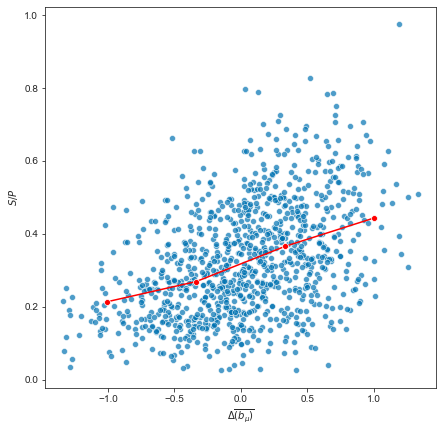

In [89]:
f, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x="bin_mn", y="ratio", data=bin_mu_delta, alpha=0.7)
sns.lineplot(x="bin_mn", y="ratio", data=sp_mu_means, color="r", marker= "o")
ax.set(ylabel="$S/P$", xlabel="$\Delta\overline{(b_\mu)}$")

plt.savefig("../../results/sp_deltamu.pdf")